# Examples of pyiron_nodes applications

A few examples to show how to apply pyiron_nodes to construct workflows using pyiron_workflows

### Setup environment and import modules 

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path(Path.cwd()).parent))
# sys.path

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%config IPCompleter.evaluation='unsafe'

### Create and run a simple workflow (plot trigonometric functions)

Note: The nodes in math and plotting have been created with an LLM and using aider

{'plot_sin__axis': <Axes: title={'center': 'sin(x)'}>,
 'plot_cos__axis': <Axes: title={'center': 'cos(x)'}>,
 'plot_tan__axis': <Axes: title={'center': 'tan(x)'}>,
 'plot_arcsin__axis': <Axes: title={'center': 'arcsin(x)'}>,
 'plot_arccos__axis': <Axes: title={'center': 'arccos(x)'}>,
 'plot_arctan__axis': <Axes: title={'center': 'arctan(x)'}>}

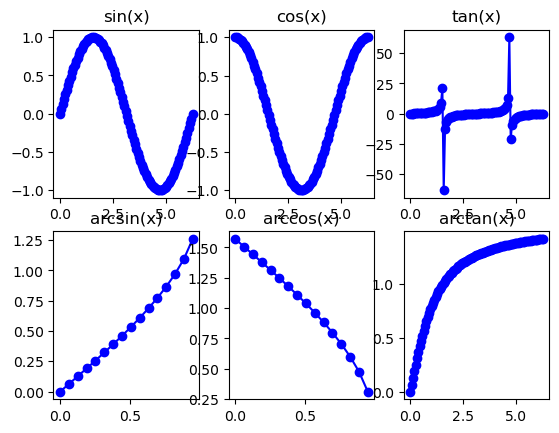

In [4]:
from pyiron_workflow import Workflow
import pyiron_nodes as pn

# Create a new workflow                                                                                       
wf = Workflow("trigonometric_functions")

# Create a Linspace node to generate a vector  
import numpy as np

wf.linspace = pn.plotting.Linspace(start=0, stop=2 * np.pi, num=100)

# Create nodes for each trigonometric function                                                                
wf.sin = pn.math.Sin(x=wf.linspace)
wf.cos = pn.math.Cos(x=wf.linspace)
wf.tan = pn.math.Tan(x=wf.linspace)
wf.arcsin = pn.math.Arcsin(x=wf.linspace)
wf.arccos = pn.math.Arccos(x=wf.linspace)
wf.arctan = pn.math.Arctan(x=wf.linspace)

# Create a subplot node                                                                                       
wf.subplot = pn.plotting.Subplot(nrows=2, ncols=3)

# Create plot nodes for each trigonometric function                                                           
wf.plot_sin = pn.plotting.Plot(x=wf.linspace, y=wf.sin, axis=wf.subplot[0, 0], title='sin(x)')
wf.plot_cos = pn.plotting.Plot(x=wf.linspace, y=wf.cos, axis=wf.subplot[0, 1], title='cos(x)')
wf.plot_tan = pn.plotting.Plot(x=wf.linspace, y=wf.tan, axis=wf.subplot[0, 2], title='tan(x)')
wf.plot_arcsin = pn.plotting.Plot(x=wf.linspace, y=wf.arcsin, axis=wf.subplot[1, 0], title='arcsin(x)')
wf.plot_arccos = pn.plotting.Plot(x=wf.linspace, y=wf.arccos, axis=wf.subplot[1, 1], title='arccos(x)')
wf.plot_arctan = pn.plotting.Plot(x=wf.linspace, y=wf.arctan, axis=wf.subplot[1, 2], title='arctan(x)')

# Execute the workflow                                                                                        
wf()


### Pyiron atomistic examples

### Create a supercell

In [5]:
from pyiron_workflow import Workflow
import pyiron_nodes as pn
                                                                                                         
# Create a new workflow                                                                                     
wf = Workflow("bulk_structure")                                                                             
                                                                                                         
# Create a cubic_bulk node to generate an aluminum cubic supercell of size 3x3x3                                                              
wf.supercell = pn.atomistic.structure.build.CubicBulkCell(element='Al', cell_size=3)
                                                                                                         
# Execute the workflow                                                                                      
out = wf() 

In [6]:
wf.outputs.supercell__structure.value.plot3d(particle_size=3)

NGLWidget()

### Compute supercell energy

In [7]:
from pyiron_workflow import Workflow
import pyiron_nodes as pn
                      
# Create a new workflow  
wf = Workflow("bulk_structure") 
   
# Create a cubic_bulk node to generate an aluminum cubic supercell of size 3x3x3 with vacancy at atom index 0
wf.supercell = pn.atomistic.structure.build.CubicBulkCell(element='Al', cell_size=3, vacancy_index=0)
wf.calc = pn.atomistic.calculator.ase.Minimize(structure=wf.supercell)
                     
# Execute the workflow
out = wf()

print (f"total energy: {wf.calc.outputs.out.final.energy.value}")

total energy: 0.7996059979213341


In [8]:
wf.supercell.bulk.outputs.structure.value.plot3d(particle_size=3)

NGLWidget()

In [9]:
wf.calc.outputs.out.final.energy.value

0.7996059979213341

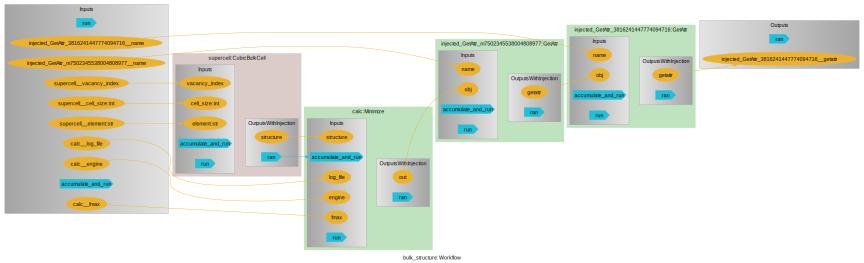

In [10]:
wf.draw(size=(12,15))

### Compute vacancy formation energy

In [11]:
from pyiron_workflow import Workflow
import pyiron_nodes as pn
                      
# Create a new workflow  
wf = Workflow("bulk_structure") 
   
# Create a cubic_bulk node to generate an aluminum cubic supercell of size 3x3x3 with vacancy at atom index 0
wf.supercell = pn.atomistic.structure.build.CubicBulkCell(element='Al', cell_size=3, vacancy_index=0)
wf.calc = pn.atomistic.calculator.ase.Minimize(structure=wf.supercell)
                     
# Execute the workflow
out = wf()

def compute_vacancy_formation_energy(pure_bulk_energy, defective_bulk_energy, n_atoms_in_pure_bulk_cell):
    mu = pure_bulk_energy / n_atoms_in_pure_bulk_cell
    return defective_bulk_energy - pure_bulk_energy + mu

# Compute the energy of a pure bulk cell
pure_bulk_wf = Workflow("pure_bulk")
pure_bulk_wf.supercell = pn.atomistic.structure.build.CubicBulkCell(element='Al', cell_size=3)
pure_bulk_wf.calc = pn.atomistic.calculator.ase.Minimize(structure=pure_bulk_wf.supercell)
pure_bulk_out = pure_bulk_wf()

# Compute the vacancy formation energy
n_atoms_in_pure_bulk_cell = pn.atomistic.structure.calc.NumberOfAtoms(pure_bulk_wf.supercell).run()
vacancy_formation_energy = compute_vacancy_formation_energy(pure_bulk_wf.calc.outputs.out.final.energy.value, wf.calc.outputs.out.final.energy.value, n_atoms_in_pure_bulk_cell)
print(f"vacancy formation energy: {vacancy_formation_energy}")


vacancy formation energy: 0.9603250896481264


### Use another engine

In [12]:
from pyiron_workflow import Workflow
import pyiron_nodes as pn

wf = Workflow('M3GNet')
wf.engine = pn.atomistic.engine.ase.M3GNet()
wf.get_chem_pot = pn.atomistic.property.thermodynamics.GetChemicalPotential('W', engine=wf.engine)

wf.run()

{'get_chem_pot__chemical_potential': -12.87940788269043}

### Compute Elastic Constants

#### Single point calculation

In [13]:
from pyiron_workflow import Workflow
import pyiron_nodes as pn

wf = Workflow("elastic_constants") 
atomistic = pn.atomistic
from pyiron_nodes.atomistic.property.elastic import InputElasticTensor

wf.engine = atomistic.engine.ase.M3GNet() 
wf.supercell = atomistic.structure.build.CubicBulkCell(
    element='Al', 
    cell_size=3, 
    vacancy_index=0
)
wf.calc = atomistic.calculator.ase.Static(
    structure=wf.supercell, 
    engine=wf.engine
)
wf.elastic = atomistic.property.elastic.ElasticConstants(
    structure=wf.supercell, 
    engine=wf.engine, 
    parameters=InputElasticTensor(eps_range=0.01)
)
out = wf.run()

print (f'Bulkmodulus: {out.elastic__elastic.BV} GPa')

/Users/huber/anaconda3/envs/pyiron_311/lib/python3.11/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


Bulkmodulus: 53.49261969693336 GPa


#### Parametric study

In [14]:
atomistic = pn.atomistic
from pyiron_nodes.atomistic.property.elastic import InputElasticTensor

@Workflow.wrap.as_macro_node('elastic')
def compute_elastic_constants(
    wf, 
    element='Fe', 
    parameters=InputElasticTensor(eps_range=0.02)
):
    
    wf.engine = atomistic.engine.ase.M3GNet()
    wf.supercell = atomistic.structure.build.CubicBulkCell(
        element=element, 
        cell_size=3, 
        vacancy_index=0
    )
    wf.calc = atomistic.calculator.ase.Static(
        structure=wf.supercell, 
        engine=wf.engine
    )
    wf.elastic = atomistic.property.elastic.ElasticConstants(
        structure=wf.supercell, 
        engine=wf.engine, 
        parameters=parameters
    )
    return wf.elastic.outputs.elastic
    
out = compute_elastic_constants(element='Ni').run()
out.elastic.BV

207.85455655693568

In [16]:
out.elastic.C

array([[243.84740654, 189.85813156, 189.85813156,   0.        ,
          0.        ,   0.        ],
       [189.85813156, 243.84740654, 189.85813156,   0.        ,
          0.        ,   0.        ],
       [189.85813156, 189.85813156, 243.84740654,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , 104.96827122,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        104.96827122,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        , 104.96827122]])

In [17]:
# compute_elastic_constants().iter(element=['Al', 'Ni', 'Fe'], parameters=[InputElasticTensor(eps_range=0.01), InputElasticTensor(eps_range=0.02)])

In [18]:
%%time
#compute_elastic_constants().iter(element=['Al', 'Ni', 'Fe'], parameters=[InputElasticTensor(eps_range=eps) for eps in [0.001, 0.01, 0.02, 0.1]])

CPU times: user 4 μs, sys: 1e+03 ns, total: 5 μs
Wall time: 12.9 μs


### Compute phonons

#### Workflow

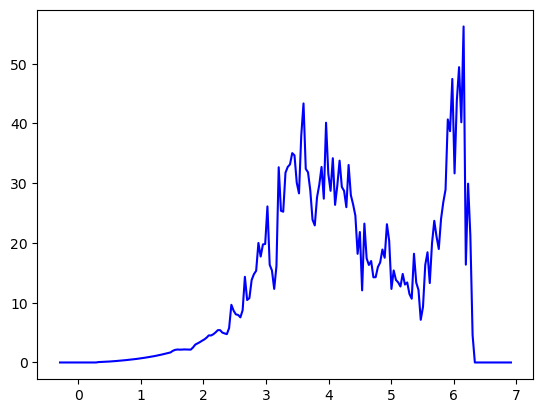

In [19]:
from pyiron_workflow import Workflow
import pyiron_nodes as pn

wf = Workflow("phonons") 
atomistic = pn.atomistic
wf.engine = atomistic.engine.ase.M3GNet() #.run()
wf.supercell = atomistic.structure.build.CubicBulkCell(
    element='Al', 
    cell_size=2, 
    vacancy_index=0
)
wf.calc = atomistic.calculator.ase.Static(structure=wf.supercell, engine=wf.engine)
wf.phonon = atomistic.property.phonons.CreatePhonopy(
    structure=wf.supercell,
    engine=wf.engine,
)
# wf.check = atomistic.property.phonons.check_consistency(phonopy=wf.phonon.outputs.phonopy)
wf.phonon_dos = atomistic.property.phonons.GetTotalDos(phonopy=wf.phonon.outputs.phonopy)
wf.plot_dos = pn.plotting.Plot(
    x=wf.phonon_dos.frequency_points,
    y=wf.phonon_dos.total_dos, 
    symbol='', 
    title='phonon dos'
)

out = wf.run()

Access output data directly:

In [20]:
wf.phonon_dos.outputs.total_dos.value

,frequency_points,total_dos
0,-0.292875,0.0
1,-0.256830,0.0
2,-0.220785,0.0
3,-0.184740,0.0
4,-0.148695,0.0
...,...,...
196,6.771917,0.0
197,6.807962,0.0
198,6.844007,0.0
199,6.880052,0.0


#### Rewrite workflow as macro

In [21]:
from pyiron_workflow import Workflow
import pyiron_nodes as pn

wf = Workflow("phonons") 
atomistic = pn.atomistic

@Workflow.wrap.as_macro_node('phonon_dos_plot')
def plot_phonon_dos(
    wf, 
    element='Fe', 
    cell_size=2, 
    parameters: atomistic.property.phonons.PhonopyParameters.dataclass | None = None
):
    wf.engine = atomistic.engine.ase.M3GNet()
    wf.supercell = atomistic.structure.build.CubicBulkCell(
        element=element, 
        cell_size=cell_size, 
        vacancy_index=0
    )
    wf.calc = atomistic.calculator.ase.Static(
        structure=wf.supercell, 
        engine=wf.engine
    )
    wf.phonon = atomistic.property.phonons.CreatePhonopy(
        structure=wf.supercell,
        engine=wf.engine,
        parameters=parameters
    )
    
    wf.phonon_dos = atomistic.property.phonons.GetTotalDos(
        phonopy=wf.phonon.outputs.phonopy
    )
    wf.plot_dos = pn.plotting.Plot(
        x=wf.phonon_dos.frequency_points, 
        y=wf.phonon_dos.total_dos, 
        symbol='', 
        title='phonon dos'
    )
    return wf.plot_dos

,element,phonon_dos_plot
0,Al,<module 'matplotlib.pyplot' from '/Users/huber...
1,Fe,<module 'matplotlib.pyplot' from '/Users/huber...


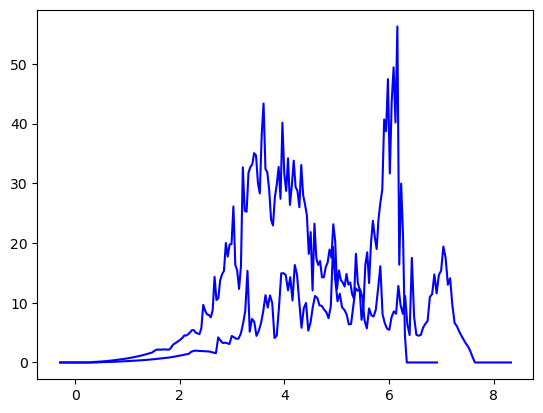

In [22]:
plot_phonon_dos().iter(element=['Al', 'Fe'])

TODO: change colors and add label

,parameters,phonon_dos_plot
0,"PhonopyParameters.dataclass(distance=0.1, is_p...",<module 'matplotlib.pyplot' from '/Users/huber...
1,"PhonopyParameters.dataclass(distance=0.001, is...",<module 'matplotlib.pyplot' from '/Users/huber...


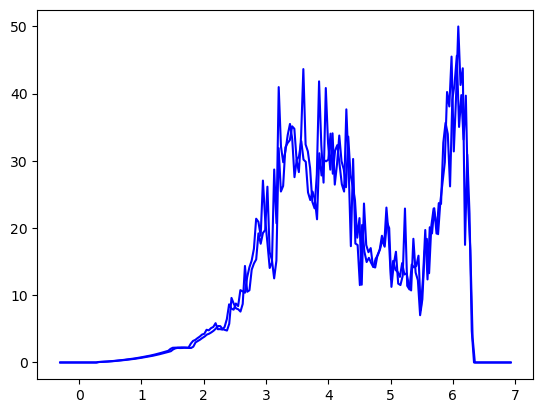

In [23]:
plot_phonon_dos(element='Al').iter(
    parameters=[
        atomistic.property.phonons.PhonopyParameters.dataclass(distance=d) 
        for d in [0.1, 0.001]
    ]
)

### Wishlist

- capture errors in iter (return na ratther than stop)
- provide iter capability inside workflows/macros
  - Note: Functionality is there by instantiating a `For` node -- `.iter()` syntax is what's not there
- unpack data_classes in iter dataframe
- provide a simple way to transfer a dataclass as list of **kwargs to function call
- provide option to add original function from where to take the docstring info (for the last two points see comparison below) 

### Comparison of the data classes

#### My implementation

In [24]:
from pyiron_nodes.dev_tools import wf_data_class
from typing import Optional, Union

from phonopy.api_phonopy import Phonopy


@wf_data_class(doc_func=Phonopy.generate_displacements)
class InputPhonopyGenerateSupercells:
    distance: float = 0.01
    is_plusminus: Union[str, bool] = "auto"
    is_diagonal: bool = True
    is_trigonal: bool = False
    number_of_snapshots: Optional[int] = None
    random_seed: Optional[int] = None
    temperature: Optional[float] = None
    cutoff_frequency: Optional[float] = None
    max_distance: Optional[float] = None

**Note:** Behaves like a dict, e.g.

In [25]:
dc = InputPhonopyGenerateSupercells()
dc.keys()

dict_keys(['distance', 'is_plusminus', 'is_diagonal', 'is_trigonal', 'number_of_snapshots', 'random_seed', 'temperature', 'cutoff_frequency', 'max_distance'])

#### Liam's implementation

In [26]:
dc = atomistic.property.phonons.PhonopyParameters()

In [27]:
dc.dataclass.distance

0.01

In [28]:
dc.outputs

In [29]:
out = dc.run()
out

PhonopyParameters.dataclass(distance=0.01, is_plusminus='auto', is_diagonal=True, is_trigonal=False, number_of_snapshots=None, random_seed=None, temperature=None, cutoff_frequency=None, max_distance=None)